# Power Measurement on Alveo

This notebook introduces the PYNQ on Alveo power measurement capabilities.

Notice that power monitoring functionalities *will not work* on Amazon AWS F1.

## Recording power data

We rely on the `sensors` attribute of Alveo `Device` to get a dictionary of rails that are monitored. Each rail contains a voltage sensor and optionally an additional current sensor. We use `active_device` as target device for this notebook, which represent the first device in the system.

First we'll get the available rails and print out their details

In [1]:
from pynq import Device

sensors = Device.active_device.sensors
sensors

{'0v85': XrtRail {name=0v85, voltage=Sensor {name=0v85, value=0.856V}},
 '12v_aux': XrtRail {name=12v_aux, voltage=Sensor {name=12v_aux_vol, value=12.132V}, current=Sensor {name=12v_aux_curr, value=1.0170000000000001A}, power=Sensor {name=12v_aux_power, value=12.338244000000001W}},
 '12v_pex': XrtRail {name=12v_pex, voltage=Sensor {name=12v_pex_vol, value=12.152000000000001V}, current=Sensor {name=12v_pex_curr, value=1.1400000000000001A}, power=Sensor {name=12v_pex_power, value=13.853280000000003W}},
 '12v_sw': XrtRail {name=12v_sw, voltage=Sensor {name=12v_sw, value=12.168000000000001V}},
 '1v8': XrtRail {name=1v8, voltage=Sensor {name=1v8, value=1.836V}},
 '3v3_aux': XrtRail {name=3v3_aux, voltage=Sensor {name=3v3_aux_vol, value=3.352V}},
 '3v3_pex': XrtRail {name=3v3_pex, voltage=Sensor {name=3v3_pex_vol, value=3.349V}, current=Sensor {name=3v3_pex_curr, value=0.0A}, power=Sensor {name=3v3_pex_power, value=0.0W}},
 'mgt0v9avcc': XrtRail {name=mgt0v9avcc, voltage=Sensor {name=mgt0v9a

To get the value programatically each sensor has a `.value` property that returns the currently sampled voltage or current in `V` or `A` as appropriate. The value is resampled on each access of the property. For rails that have both a voltage and current sensor the power is also available directly as a derived sensor.

In [2]:
sensors['vccint'].voltage.value

0.851

The `pmbus` sub-package provides a `DataRecorder` class than periodically sample sensors while other code is running. It takes the sensors to record as construction parameters. For this example we are going to record the power of the two 12V supplies to the board to get an approximation of total board power and the power going to the internals of the FPGA.

In [3]:
from pynq.pmbus import DataRecorder

recorder = DataRecorder(sensors["12v_aux"].power,
                        sensors["12v_pex"].power,
                        sensors["vccint"].power)

The target for our power measurements will be the `mmult` accelerator shown in the notebook [1-efficient-accelerator-scheduling](./1-efficient-accelerator-scheduling.ipynb).

To proceed, we first have to download the overlay and instantiate the required buffers.

In [4]:
import pynq
import numpy as np
import time
import os

KERNEL_SIZE = 512
KERNEL_SHAPE = (KERNEL_SIZE, KERNEL_SIZE)

ol = pynq.Overlay('advanced.xclbin')
mmult = ol.mmult_1

in_a = pynq.allocate(shape=KERNEL_SHAPE, dtype='i4')
in_b = pynq.allocate(shape=KERNEL_SHAPE, dtype='i4')
out = pynq.allocate(shape=KERNEL_SHAPE, dtype='i4')
in_a[:] = np.random.randint(100, size=KERNEL_SHAPE, dtype='i4')
in_b[:] = np.random.randint(100, size=KERNEL_SHAPE, dtype='i4')

We can now use the `record` function to sample the sensors at a specified interval. Using the `record` function in a `with` statement means that the recording will stop automatically at the end of the block even if exceptions or other abnormal control flow occurs. In this example we are sampling every 100 ms.

We use the `%timeit` magic to run the kernel multiple times, so that we can actually see a noticeable power draw on the FPGA. 

In [5]:
with recorder.record(0.1): # Sample every 0.1 seconds
    time.sleep(3)
    recorder.mark()
    in_a.sync_to_device()
    in_b.sync_to_device()
    %timeit mmult.call(in_a, in_b, out)
    out.sync_from_device()
    recorder.mark()
    time.sleep(3)

3.56 ms ± 3.64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Visualizing power data

The DataRecorder exposes the data as a Pandas DataFrame. Pandas is a widely used library for data manipulation providing easy methods for selecting, plotting and performing computations on tabular data.

In [6]:
f = recorder.frame

To get a quick feel for the data we can use the `head` function of the dataframe to return the first five entries. Each entry is indexed by the time the measurement was taken with the columns being the `V` or `A` measurement as appropriate for the sensor. There is also a _Mark_ column that increments each time the `.mark` or `.record` functions are called and can be used to easily separate out the various phases of execution

In [7]:
f.head()

,Mark,12v_aux_power,12v_pex_power,vccint_power
2020-01-06 15:03:57.803833,0.0,12.622811,13.806738,10.028184
2020-01-06 15:03:57.912603,0.0,12.622811,13.767083,10.028184
2020-01-06 15:03:58.017679,0.0,12.560760,13.839989,9.987336
2020-01-06 15:03:58.122756,0.0,12.517371,13.928598,10.000952
2020-01-06 15:03:58.227834,0.0,12.486915,13.892022,10.106476


We can create a new column in the table containing the board power. Board power can be usefully approximated by summation of the two 12V rails. We can also rename the `vccint` rail to something more readable. We can also clean up the data-frame by removing the two seperate 12V rails

In [8]:
import pandas as pd
powers = pd.DataFrame(index=f.index)
powers['board_power'] = f['12v_aux_power'] + f['12v_pex_power']
powers['fpga_power'] = f['vccint_power']

Finally we can use built in Pandas plotting functionality to draw a graph of the power usage of both the FPGA and the entire board.

Text(0, 0.5, 'Power (W)')

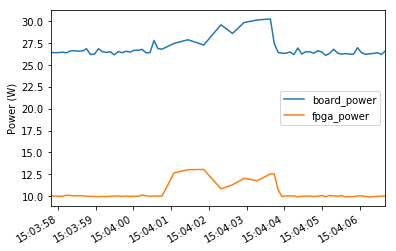

In [9]:
%matplotlib inline
ax = powers.plot()
ax.set_ylabel("Power (W)")

## Cleaning up

As last step, let's free buffers and accelerator context.

In [10]:
del in_a
del in_b
del out
ol.free()

Copyright (C) 2020 Xilinx, Inc